# Convert Human Pose MPI Dataset

Data structure:
- `data[2]` = 2 x 7 x 100 array
- `data[2][0]` = x locations
- `data[2][0]` = y locations
- ordering is `0 Head, 1 Right wrist, 2 Left wrist, 3 Right elbow, 4 Left elbow, 5 Right shoulder and 6 Left shoulder`

In [101]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils

In [2]:
DATA_STORE = '/data_store_nas/'
fp_dataset = join(DATA_STORE, 'datasets/people/youtube_poses')
dir_fp_frames = join(fp_dataset, 'YouTube_Pose_dataset_1.0/GT_frames')

In [3]:
dirs_frames = glob(join(dir_fp_frames, '*'))
fps_frames = {}
for dir_frames in dirs_frames:
  fps_frames[dir_frames] = join(dir_frames, '*')

In [4]:
fp_pose_data = join(fp_dataset, 'YouTube_Pose_dataset_1.0/YouTube_Pose_dataset.mat')
pose_data = scipy.io.loadmat(fp_pose_data)['data'][0]

In [105]:
# convert data to pandas DF for sanity
poses = []
for i, pose in enumerate(pose_data):
  pose_pts = pose[2]
  for j in range(pose_pts.shape[2]): # 100 frames
    x = [pose_pts[0][i][j] for i in range(7)]
    y = [pose_pts[1][i][j] for i in range(7)]
    poses.append({
      'head_x': x[0],
      'head_y': y[0],
      'wrist_right_x': x[1],
      'wrist_right': y[1],
      'wrist_left_x': x[2], 
      'wrist_left_x': y[2],
      'elbow_right_x': x[3],
      'elbow_right_y': y[3],
      'elbow_left_x': x[4], 
      'elbow_left_y': y[4],
      'shoulder_right_x': x[5],
      'shoulder_right_y': y[5],
      'shoulder_left_x': x[6], 
      'shoulder_left_y':  y[6]
      })
df_poses = pd.DataFrame.from_dict(poses)
df_poses.to_csv('poses.csv')

In [106]:
# function to create spaced colormaps as RGB values

import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors


In [6]:
# https://matplotlib.org/examples/color/colormaps_reference.html
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]


In [7]:
def scale_pt(pt_orig, offset_xy, video_size, im_plt_wh):
  #pt_orig = np.array([pose_pts[0][j][i], pose_pts[1][j][i]])  # x,y
  pt_orig[0] += offset_cx
  pt_orig[1] += offset_cy
  pt_norm = pt_orig / video_size
  pt_scaled_plt = tuple(map(int, pt_norm * im_plt_wh ))
  return pt_scaled_plt

In [8]:
def jitter_clr(clr, amt=10, mono=False):
  clr = list(clr)
  if mono:
    r = randint(-amt, amt)
    for i in range(len(clr)):
      clr[i] = max(0, min(255, clr[i] + r))
  else:
    for i in range(len(clr)):
      r = randint(-amt, amt)
      clr[i] = max(0, min(255, clr[i] + r))
  return clr

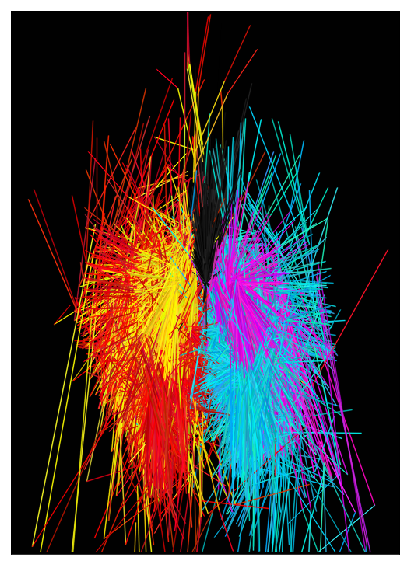

In [76]:
radius = 1
stroke_weight = 1

im_plt = np.ones((700, 500, 3)).astype(np.uint8)
im_plt_wh = im_plt.shape[:2][::-1]
frame_cx = im_plt_wh[0] / 2
# nwh = im_plt.shape[:2][::-1]
colors = get_color_map(cmap='Accent', ncolors=4, bgr=True)

joints = {
  'elbow_shoulder_right': (3, 5, (5,220,250)),
  'elbow_shoulder_left': (4, 6, (220,5,220)),
  'hand_elbow_right': (1, 3, (5,5,220)),
  'hand_elbow_left': (2, 4, (220,200,5)),
}

head_clr_mono = 20
head_clr = (head_clr_mono, head_clr_mono, head_clr_mono)


for k, pose in enumerate(pose_data):
  offset_ltrb = pose[6][0]
  video_scale = pose[5][0]
  #print(video_scale)
  video_size = pose[7][0][::-1]
  owh = pose[7][0][::-1]
  pose_pts = pose[2]

  for i in range(pose_pts.shape[2]): # 100 frames
    frame_id = pose[3][0][i]
    body_cx = int(((pose_pts[0][6][i] - pose_pts[0][5][i]) / 2) + pose_pts[0][5][i])
    min_y = min(pose_pts[0][6][i], pose_pts[1][6][i])
    body_cy = int(((pose_pts[1][6][i] - pose_pts[1][5][i]) / 2) + min_y)
    offset_cx = video_size[0] // 2 - body_cx
    offset_cy = video_size[1] // 2 - body_cy
    offset_xy = (offset_cx, offset_cy)

    # add head
    pt1 = [pose_pts[0][0][i], pose_pts[1][0][i]]
    pt1 = scale_pt(pt1, offset_xy, video_size, im_plt_wh)
    pt2 = [body_cx, body_cy]
    pt2 = scale_pt(pt2, offset_xy, video_size, im_plt_wh)
    clr = jitter_clr(head_clr, amt=25, mono=True)
    #cv.circle(im_plt, pt1, radius, clr, -1, cv.LINE_AA)
    cv.line(im_plt, pt1, pt2, clr, stroke_weight, cv.LINE_AA)

    for m, j in enumerate(joints.items()):
      j = j[1]  # value
      pt1_orig = [pose_pts[0][j[0]][i], pose_pts[1][j[0]][i]]
      pt1 = scale_pt(pt1_orig, offset_xy, video_size, im_plt_wh)
      pt2_orig = [pose_pts[0][j[1]][i], pose_pts[1][j[1]][i]]
      pt2 = scale_pt(pt2_orig, offset_xy, video_size, im_plt_wh)
      clr = jitter_clr(j[2], amt=50)
      #cv.circle(im_plt, pt1, radius, clr, -1, cv.LINE_AA)
      #cv.circle(im_plt, pt2, radius, clr, -1, cv.LINE_AA)
      cv.line(im_plt, pt1, pt2, clr, stroke_weight, cv.LINE_AA)

    
cv.imwrite('output_white.png', im_plt)
plt.figure(figsize=(10,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(im_plt, cv.COLOR_BGR2RGB))

Try to center the lines and normalize it

In [77]:
pose = pose_data[8]

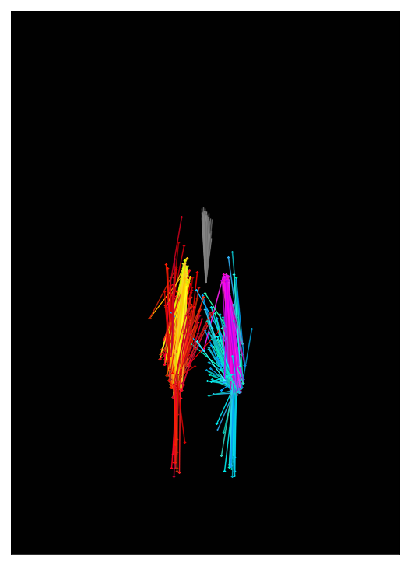

In [81]:
stroke_weight = 1
radius = 1

im_plt = np.ones((700, 500, 3)).astype(np.uint8)
im_plt_wh = im_plt.shape[:2][::-1]
frame_cx = im_plt_wh[0] / 2
# nwh = im_plt.shape[:2][::-1]
colors = get_color_map(cmap='Accent', ncolors=4, bgr=True)

joints = {
  'elbow_shoulder_right': (3, 5, (5,220,250)),
  'elbow_shoulder_left': (4, 6, (220,5,220)),
  'hand_elbow_right': (1, 3, (5,5,220)),
  'hand_elbow_left': (2, 4, (220,200,5)),
}

head_clr_mono = 120
head_clr = (head_clr_mono, head_clr_mono, head_clr_mono)

im_plt = np.ones((700, 500, 3)).astype(np.uint8)
im_plt_wh = im_plt.shape[:2][::-1]
frame_cx = im_plt_wh[0] / 2

offset_ltrb = pose[6][0]
video_scale = pose[5][0]
video_size = pose[7][0][::-1]
owh = pose[7][0][::-1]
pose_pts = pose[2]

for i in range(pose_pts.shape[2]): # 100 frames
  
  cx = int(((pose_pts[0][6][i] - pose_pts[0][5][i]) / 2) + pose_pts[0][5][i])
  min_y = min(pose_pts[0][6][i], pose_pts[1][6][i])
  cy = int(((pose_pts[1][6][i] - pose_pts[1][5][i]) / 2) + min_y)
  
  # cxy becomes the new 0,0 origin
  
  # add head
  pt1 = [pose_pts[0][0][i] - cx, pose_pts[1][0][i], cy]
  pt1 = scale_pt(pt1, offset_xy, video_size, im_plt_wh)
  pt2 = [body_cx, body_cy]
  pt2 = scale_pt(pt2, offset_xy, video_size, im_plt_wh)
  clr = jitter_clr(head_clr, amt=25, mono=True)
  #cv.circle(im_plt, pt1, radius, clr, -1, cv.LINE_AA)
  cv.line(im_plt, pt1, pt2, clr, stroke_weight, cv.LINE_AA)

  for m, j in enumerate(joints.items()):
    j = j[1]  # value
    pt1_orig = [pose_pts[0][j[0]][i], pose_pts[1][j[0]][i]]
    pt1 = scale_pt(pt1_orig, offset_xy, video_size, im_plt_wh)
    pt2_orig = [pose_pts[0][j[1]][i], pose_pts[1][j[1]][i]]
    pt2 = scale_pt(pt2_orig, offset_xy, video_size, im_plt_wh)
    clr = jitter_clr(j[2], amt=50)
    cv.circle(im_plt, pt1, radius, clr, -1, cv.LINE_AA)
    cv.circle(im_plt, pt2, radius, clr, -1, cv.LINE_AA)
    cv.line(im_plt, pt1, pt2, clr, stroke_weight, cv.LINE_AA)
  

cv.imwrite('output_white.png', im_plt)
plt.figure(figsize=(10,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(im_plt, cv.COLOR_BGR2RGB))